#1. Import Neccesary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
    
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import cv2
import imutils
from imutils import paths
from skimage.io import imread

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#2. Connect to your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#3. Unzip the Dataset File

In [ ]:
!unzip "/content/gdrive/My Drive/Medplants Resources/medplants.zip"

#4. Load and Split the Dataset and Store into DataFrame

In [ ]:
main_folder = 'medplants'
sub_folders = Path(main_folder ).glob('*')

rows = []
for folder in sub_folders:
	class_name = str(folder).replace("medplants/","")
	for file in os.listdir(folder):
		data = [str(folder)+"/"+file, class_name]
		rows.append(data)

#store the all data inside a pandas dataframe
df = pd.DataFrame(rows, columns=["Full Path", "Class Name"])

#split the frame with stratify=target_column to maintain equal split portions across all classes
x_train, x_test, y_train, y_test = train_test_split(df["Full Path"], df["Class Name"], test_size=0.2, random_state=7, shuffle=True, stratify=df["Class Name"])

#store the splitted portions into dataframe
dftrain = pd.DataFrame({'Full Path':x_train, 'Class Name':y_train})
dftest = pd.DataFrame({'Full Path':x_test, 'Class Name':y_test})

print(dftrain)
print(dftest)

                                               Full Path  \
3507   medplants/Peperomia pellucida (Ulasimang-bato)...   
185    medplants/Combretum indicum (Niyog-niyogan)/ci...   
8231       medplants/Senna alata (Acapulco)/salata36.jpg   
8705    medplants/Vitex negundo (Lagundi)/vnegundo87.jpg   
7568      medplants/Senna alata (Acapulco)/salata809.jpg   
...                                                  ...   
4368   medplants/Blumea balsamifera (Sambong)/bbalsam...   
4471   medplants/Blumea balsamifera (Sambong)/bbalsam...   
6868   medplants/Momordica charantia (Ampalaya)/mchar...   
8677   medplants/Vitex negundo (Lagundi)/vnegundo105.jpg   
10378  medplants/Allium sativum (Garlic)/astivumv2308...   

                                 Class Name  
3507   Peperomia pellucida (Ulasimang-bato)  
185       Combretum indicum (Niyog-niyogan)  
8231                 Senna alata (Acapulco)  
8705                Vitex negundo (Lagundi)  
7568                 Senna alata (Acapulco)  
...

#5. Define Custom Functions

In [ ]:
#function to convert dataframe into image data generators
def df_to_generator(df, x, y, batch_size, seed, shuffle, class_mode, target_size):
  datagen=ImageDataGenerator()
  generator=datagen.flow_from_dataframe(
  dataframe=df,
  x_col=x,
  y_col=y,
  batch_size=batch_size,
  seed=seed,
  shuffle=shuffle,
  class_mode=class_mode,
  target_size = target_size)

  return generator

#function to convert dataframe into image data generators
def extract_feat(extractor, img_data):
  feat = extractor.predict(img_data)
  return feat

#function predict on a single image
def predict_image_knn(extractor, model, classes, img_path, size):

  # load the image
  image_orig = cv2.imread(img_path)
  image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
  print(img_path)

  # pre-process the image for classification
  image = cv2.resize(image_orig, (size, size))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  feat = extractor.predict(image)

  result = model.predict(feat)
  class_id = result[0]
  classification = classes[class_id]
  
  plt.figure(figsize=(8, 8))
  plt.imshow(image_orig)
  plt.show()
  print("[PREDICTION] {}".format(classification))

#6. Load Model

In [ ]:
model_dir = "/content/gdrive/My Drive/Medplants Resources/CNN-MedNet.h5"
cnn_model = load_model(model_dir)
cnn_model.summary()

#7. Define Constants

In [ ]:
IMG_SIZE = 224
BATCH_SIZE =32
SEED =42

#define the feature extract which which is MobileNetV3 plus an Average Pooling layer
mobilenetv3 = MobileNetV3Large(include_top=False, 
                               input_shape = (IMG_SIZE,IMG_SIZE, 3))
x = GlobalAveragePooling2D()(mobilenetv3.output)

feature_extractor = Model(name="feature_extractor", inputs=mobilenetv3.input, outputs=x)
for layer in feature_extractor.layers:
  layer.trainable = False
feature_extractor.summary()

#8. Prepare Dataset and Extract Features

In [ ]:
train_generator = df_to_generator(dftrain, 'Full Path', 'Class Name', BATCH_SIZE, SEED, False, 'categorical', (IMG_SIZE, IMG_SIZE))
test_generator = df_to_generator(dftest, 'Full Path', 'Class Name', BATCH_SIZE, SEED, False, 'categorical', (IMG_SIZE, IMG_SIZE))

train_features = extract_feat(feature_extractor, train_generator)
train_labels = train_generator.labels

test_features = extract_feat(feature_extractor, test_generator)
test_labels = test_generator.labels

Found 8596 validated image filenames belonging to 10 classes.
Found 2149 validated image filenames belonging to 10 classes.


#9. The KNN Model

In [ ]:
#Define the KNN Model
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
#Evaluate the KNN Model
prediction = knn_model.predict(test_features)

print("Accuracy: {}".format(accuracy_score(test_labels, prediction)))
print("Precision: {}".format(precision_score(test_labels, prediction, average = "macro")))
print("Recall: {}".format(recall_score(test_labels, prediction, average = "macro")))
print("F1-Score: {}".format(f1_score(test_labels, prediction, average = "macro")))

Accuracy: 0.9646347138203816
Precision: 0.9650679322276723
Recall: 0.9648644579901043
F1-Score: 0.9645997394092362


medplants/Combretum indicum (Niyog-niyogan)/cindicum1100.jpg


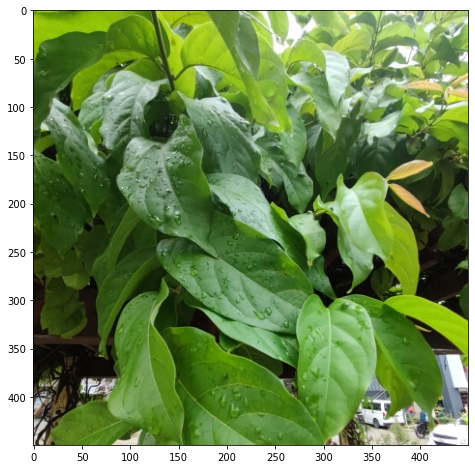

[PREDICTION] Combretum indicum (Niyog-niyogan)


In [ ]:
#Create Predictions on Single Image Using KNN

#create class labels based from dataset subfolders
main_folder = 'medplants'
sub_folders = sorted(Path(main_folder ).glob('*'))
labels = [str(x).replace("medplants/","") for x in sub_folders]

#select a random image path
folder = random.choice(labels)
path = os.path.join(main_folder, folder)
file = random.choice(os.listdir(path))
img_path = os.path.join(path, file)

predict_image_knn(feature_extractor, knn_model, labels, img_path, 224)

#10. The SVM Model

In [ ]:
#define the SVM Model
svm_model = SVC(kernel="poly")
svm_model.fit(train_features, train_labels)

SVC(kernel='poly')

In [ ]:
#Evaluate the SVM Model
prediction =svm_model.predict(test_features)

print("Accuracy: {}".format(accuracy_score(test_labels, prediction)))
print("Precision: {}".format(precision_score(test_labels, prediction, average = "macro")))
print("Recall: {}".format(recall_score(test_labels, prediction, average = "macro")))
print("F1-Score: {}".format(f1_score(test_labels, prediction, average = "macro")))

medplants/Blumea balsamifera (Sambong)/bbalsamifera994.jpg


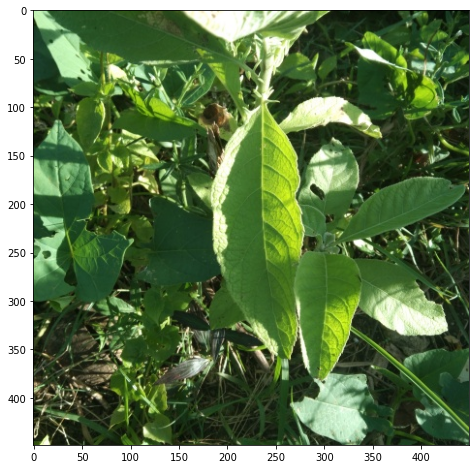

[PREDICTION] Blumea balsamifera (Sambong)


In [ ]:
#Create Predictions on Single Images Using SVM

#create class labels based from dataset subfolders
main_folder = 'medplants'
sub_folders = sorted(Path(main_folder ).glob('*'))
labels = [str(x).replace("medplants/","") for x in sub_folders]

#select a random image path
folder = random.choice(labels)
path = os.path.join(main_folder, folder)
file = random.choice(os.listdir(path))
img_path = os.path.join(path, file)

predict_image_knn(feature_extractor, svm_model, labels, img_path, 224)

#11. Compare the Models



In [ ]:
cnn_predictions = cnn_model.predict(test_generator)
y_pred = np.argmax(cnn_predictions, axis=1)
print("CNN Performance")
print("Accuracy: {}".format(accuracy_score(test_labels, y_pred)*100))
print("Precision: {}".format(precision_score(test_labels, y_pred, average = "macro")*100))
print("Recall: {}".format(recall_score(test_labels, y_pred, average = "macro")*100))
print("F1-Score: {}".format(f1_score(test_labels, y_pred, average = "macro")*100))

knn_predictions = knn_model.predict(test_features)
print("\nKNN Performance")
print("Accuracy: {}".format(accuracy_score(test_labels, knn_predictions)*100))
print("Precision: {}".format(precision_score(test_labels, knn_predictions, average = "macro")*100))
print("Recall: {}".format(recall_score(test_labels, knn_predictions, average = "macro")*100))
print("F1-Score: {}".format(f1_score(test_labels, knn_predictions, average = "macro")*100))

svm_predictions = svm_model.predict(test_features)
print("\nSVM Performance")
print("Accuracy: {}".format(accuracy_score(test_labels, svm_predictions)*100))
print("Precision: {}".format(precision_score(test_labels, svm_predictions, average = "macro")*100))
print("Recall: {}".format(recall_score(test_labels, svm_predictions, average = "macro")*100))
print("F1-Score: {}".format(f1_score(test_labels, svm_predictions, average = "macro")*100))

CNN Performance
Accuracy: 99.76733364355515
Precision: 99.76986512566887
Recall: 99.76575218464188
F1-Score: 99.76747547321342

KNN Performance
Accuracy: 96.46347138203815
Precision: 96.50679322276723
Recall: 96.48644579901044
F1-Score: 96.45997394092362

SVM Performance
Accuracy: 99.16240111679852
Precision: 99.15390575962185
Recall: 99.1651172321577
F1-Score: 99.15797718334387
